# Lecture 3

## Inverting Image Representations of Pre-trained CNNs

In preperation for this lecture we read the paper:  
[_'Understanding Deep Image Representations by Inverting Them', Mahendran and Vedaldi, 2014_](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Mahendran_Understanding_Deep_Image_2015_CVPR_paper.pdf).  
Here we want to implement their method to invert image representations of pre-trained CNNs.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [9]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
from __future__ import division

import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
# from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
# import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display

import scipy.ndimage

In [11]:
#alexnet definition that conveniently let's you grab the outputs from any layer. 
#Also we ignore dropout here
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        #convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        #fully connected layers
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        
    def forward(self, x, out_keys):
        out = {}
        out['c1'] = self.conv1(x)
        out['r1'] = F.relu(out['c1'])
        out['p1'] = self.pool1(out['r1'])
        out['r2'] = F.relu(self.conv2(out['p1']))
        out['p2'] = self.pool2(out['r2'])
        out['r3'] = F.relu(self.conv3(out['p2']))
        out['r4'] = F.relu(self.conv4(out['r3']))
        out['r5'] = F.relu(self.conv5(out['r4']))
        out['p3'] = self.pool3(out['r5'])
        out['fc1'] = F.relu(self.fc1(out['p3'].view(1, -1)))
        out['fc2'] = F.relu(self.fc2(out['fc1']))
        out['fc3'] = self.fc3(out['fc2'])
        return [out[key] for key in out_keys]

In [33]:
#load alexnet weights
model_dir = pj(os.path.dirname(cwd))
model_file_name = 'alexnet-owt-4df8aa71.pth'
alexnet_weights = torch.load(pj(model_dir, model_file_name))
#load pretrained weights into the new model definition
alexnet = AlexNet()
keys = list(alexnet.state_dict().keys())
myalexnet_weights = {}
for k, key in enumerate(alexnet_weights.keys()):
    myalexnet_weights[keys[k]] = alexnet_weights[key]
alexnet.load_state_dict(myalexnet_weights)
alexnet.eval()
alexnet.cuda(0)

AlexNet (
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (pool3): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (9216 -> 4096)
  (fc2): Linear (4096 -> 4096)
  (fc3): Linear (4096 -> 1000)
)

In [34]:
# define pre and post processing for images using the torchvision helper functions
img_size = 224

prep = transforms.Compose([
         transforms.Scale((img_size, img_size)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])
postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor.clone())
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [ ]:
postp(tensor)

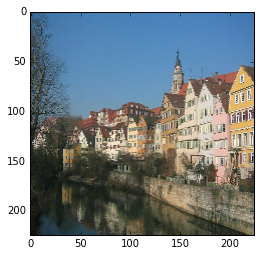

[torch.Size([1, 64, 55, 55]), torch.Size([1, 256, 13, 13])]


In [35]:
#get image
img_dir = "."
img_name = 'Tuebingen_Neckarfront.jpg'
img = Image.open(pj(img_dir, img_name))

#preprocess image
import pickle 
with open('img.pickle', 'rb') as f:
    img_torch = pickle.load(f)
    img_torch=img_torch.cuda(0)  
#show preprocessed image, dimensions are now 224x224 since this is what the network was trained on
imshow(postp(img_torch.data.cpu().squeeze()));show()

#now you can easily get the response of different layers in the network by passing a list of keys
out_layer = ['r1', 'r5']
out = alexnet(img_torch, out_layer)
#print the representation size for each output layer
print([o.size() for o in out])

## Assignment for next week
Use above network to reproduce the results from [_'Understanding Deep Image Representations by Inverting Them', Mahendran and Vedaldi, 2014_](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Mahendran_Understanding_Deep_Image_2015_CVPR_paper.pdf): reconstruct a natural image from different feature representations in AlexNet.

# Andrii Zadaianchuk 
## Implementation of the 'Understanding Deep Image Representations by Inverting Them', Mahendran and Vedaldi, 2014

In [36]:
def optimize(img_torch,alexnet): 
    
    alexnet(img_torch, ['r1'])[0]

In [202]:
class Model:
    """A class of our model that optimize the image that represent some class of AlexNet"""
    def __init__(self,opt_img, img, layer='r1', lam = 1e2 , 
                 beta=2,b_width=0.5, b_every=1, c_pct=0.3,n_pct=0.3 ,  max_iter = 300 , momentum=0.9, lr_0 = 2e0 
                ,i_max = 200, use_cuda=torch.cuda.is_available()):
        
        self.lam = lam        #weight on the L2 regularisation of the input image
        self.b_width=b_width      #bluring Gaussian kernel
        self.b_every=b_every
        self.c_pct=c_pct      # zero if not important 
        self.n_pct=n_pct       # zero if small
        self.max_iter = max_iter   #maximum number of iterations to take
        self.momentum=momentum
        self.lr_0 = lr_0       #learning rate at the start of optimization
        self.i_max = i_max      #stop deacrease of learning rate at this iteration
        self.use_cuda=use_cuda
        self.beta=beta
        
        if self.use_cuda:
            opt_img.data=opt_img.data.cuda(0)  
        
        self.opt_img=opt_img
        self.optimizer = optim.SGD([self.opt_img], lr=self.lr_0,momentum=self.momentum,nesterov=True)
        
        self.layer=layer
        self.img=img
        
    def plot_image(self):

        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cpu()
        imshow(postp(self.opt_img.data.clone().squeeze()))
        title("Iter: %s ; lam= %0.2f ; momentum = %0.2f; \n bluring_width= %0.2f; bluring_every= %s; \n c_pct= %0.2f; n_pct= %0.2f; i_max= %s; lr_0=%0.2f."%(self.n_iter,self.lam,
                                                                      self.momentum,self.b_width,self.b_every,self.c_pct,self.n_pct,self.i_max,self.lr_0))
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cuda(0)
            
    def change_lr(self):
        n_iter=self.n_iter
        i_max=self.i_max
        lr_0=self.lr_0
        #change learning rate linearly from lr_0
        #set constant learning rate after i_max iteration
        lr_min = 0.01*lr_0

        alpha = n_iter/i_max
        if (n_iter > i_max):
            alpha = 1
        lr = (1-alpha)*lr_0 + alpha*lr_min
        return lr



    def gaussian_blur(self):
        
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cpu()
            
        b_width=self.b_width
        img=self.opt_img.data.numpy()
        for i in range(3):
            color=img[0,i,:,:]
            new_color=scipy.ndimage.filters.gaussian_filter(color,b_width)
            img[0,i,:,:]=new_color
        self.opt_img.data=torch.from_numpy(img)
        
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cuda(0)
            
    def calculate_variation(self):
        b=self.beta
        #calculate variation with parameter b
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cpu()
            
        
        img=self.opt_img.data.numpy()
        variation = []
        for c in range(3):
            img_0 = img[0,c,:,:]
            img_1 = np.roll(img_0, -2, axis=1)
            img_2 = (img_0 - img_1)**2

            img_3 = np.roll(img_0, 1, axis=0)
            img_4 = (img_0 - img_3)**2

            img_5 = (img_2+img_4)**(b/2)
            variation_0 = sum(img_5)
            variation.append(variation_0) 
        variation = sum(variation)
        variation = Variable(float(variation)*torch.ones(1), requires_grad=True)
        if self.use_cuda:
            variation.data=variation.data.cuda(0)
            self.opt_img.data=self.opt_img.data.cuda(0)
        return variation
    
    def clip_to_zero(self):   
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cpu()
            self.opt_img.grad.data=self.opt_img.grad.data.cpu()
            
        c_pct,n_pct=self.c_pct,self.n_pct
        product=torch.addcmul(torch.zeros((1,3,224,224)), self.opt_img.data, self.opt_img.grad.data).sum(dim=1).abs().squeeze()
        img=self.opt_img.data.numpy()
        pix_norm=(img.squeeze()**2).sum(axis=0)
        img[0,:,pix_norm<=np.percentile(pix_norm,n_pct*100)]=0
        img[0,:,product.numpy()<=np.percentile(product.numpy(),c_pct*100)]=0
        self.opt_img.data=torch.from_numpy(img)    
        if self.use_cuda:
            self.opt_img.data=self.opt_img.data.cuda(0)
            self.opt_img.grad.data=self.opt_img.grad.data.cuda(0)

    def optimize(self, print_image=True):
        (optimizer,max_iter,lam)=(self.optimizer,self.max_iter,self.lam) 
        self.n_iter = 0     
        loss_list=[]
        representation = alexnet(self.img,[self.layer])[0].detach()
        
        while self.n_iter <= max_iter:

            lr = self.change_lr()     #new learning rate
            for param_group in optimizer.param_groups:   #change learning rate
                param_group['lr'] = lr 
            
            optimizer.zero_grad()   
            output = alexnet(self.opt_img,[self.layer])[0]
            
            class_loss = ((representation-output)**2).mean()
#           variation=self.calculate_variation()
            
            l2_loss = lam * (self.opt_img**2).mean()
            loss = l2_loss+ class_loss
            
            loss.backward()
            
            optimizer.step()

            self.clip_to_zero()      #clipping
            
            if self.n_iter%self.b_every==0:                          #bluring
                self.gaussian_blur()
            #print loss and show intermediate result image
            print('iter: %d, total loss: %.3f, class loss: %.3f,l2 loss: %.3f'%(self.n_iter, loss.data[0], 
                                                                                                  class_loss.data[0],l2_loss.data[0]))
            if print_image==True:
#                 imshow(postp(self.opt_img.data.clone().squeeze()))
                
                display.display(gcf())
            display.clear_output(wait=True)
            
            if self.use_cuda:
                class_loss.data=class_loss.data.cpu()
                l2_loss.data=l2_loss.data.cpu()
#                 variation.data=variation.data.cpu()
                loss.data=loss.data.cpu()
                
            
            loss_list.append((class_loss.data.numpy()[0],l2_loss.data.numpy()[0],loss.data.numpy()[0]))     
            
            if self.use_cuda:
                class_loss.data=class_loss.data.cuda(0)
                l2_loss.data=l2_loss.data.cuda(0)
#                 variation.data=variation.data.cuda(0)
                loss.data=loss.data.cuda(0)
            
            self.n_iter +=1
            print(self.n_iter)
        self.loss_list=loss_list  

    def plot_loss(self):
        max_iter,loss_list=self.max_iter,self.loss_list
        print('iter: %d, total loss: %.3f, class loss: %.3f, l2 loss: %.3f'%(max_iter, loss_list[-1][2], 
                                                                                              loss_list[-1][0], loss_list[-1][1]
                                                                                              )) 
        figure(figsize=(20,6))
        plot(loss_list)

In [210]:
new_img=Variable(1e-3 * torch.zeros(1, 3, img_size, img_size), requires_grad=True)
m=Model(b_width=0.1,max_iter=3000,b_every=100, beta=2,lam=1,opt_img=new_img,img=img_torch,layer='r2',
        i_max=1000,c_pct=0,n_pct=0,lr_0=4)
m.optimize()

3001


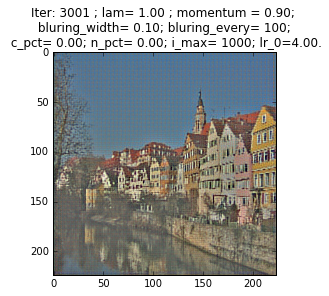

In [195]:
m.plot_image()

iter: 3000, total loss: 0.633, class loss: 0.339, l2 loss: 0.293


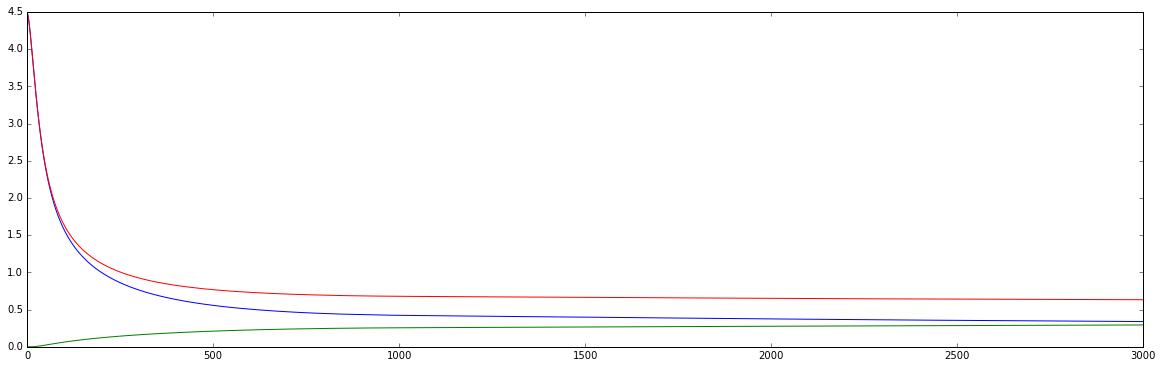

In [196]:
m.plot_loss()

In [248]:
new_img=Variable(1e-3 * torch.zeros(1, 3, img_size, img_size), requires_grad=True)
m=Model(b_width=0.1,max_iter=2000,b_every=10, beta=2,lam=1,opt_img=new_img,img=img_torch,layer='c1',
        i_max=1000,c_pct=0,n_pct=0,lr_0=5)
m.optimize()

2001


iter: 2000, total loss: 0.652, class loss: 0.376, l2 loss: 0.276


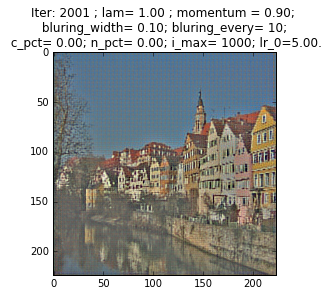

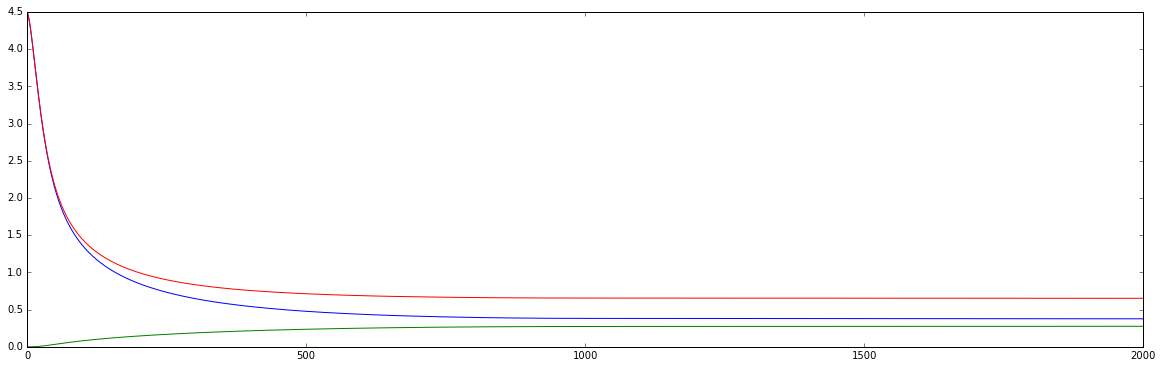

In [249]:
m.plot_image()
m.plot_loss()

In [250]:
new_img=Variable(1e-3 * torch.zeros(1, 3, img_size, img_size), requires_grad=True)
m=Model(b_width=0.1,max_iter=2000,b_every=10, beta=2,lam=1,opt_img=new_img,img=img_torch,layer='r3',
        i_max=1000,c_pct=0,n_pct=0,lr_0=5)
m.optimize()

2001


iter: 2000, total loss: 0.241, class loss: 0.162, l2 loss: 0.079


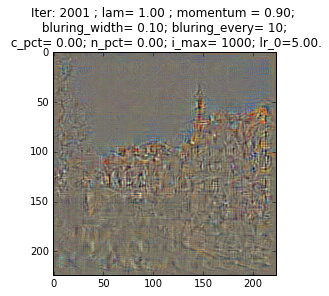

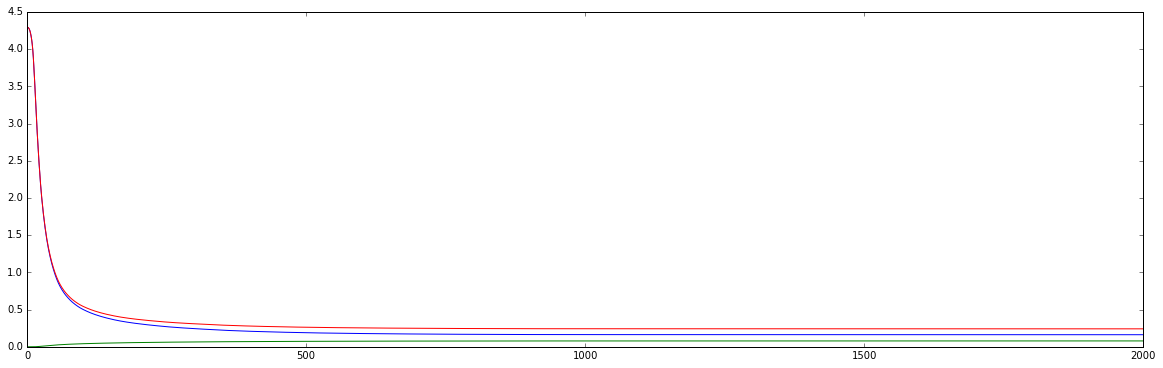

In [251]:
m.plot_image()
m.plot_loss()